In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import pandas as pd
import cartopy.mpl.ticker as cticker
from matplotlib.animation import FuncAnimation
import imageio.v2 as imageio

##Read the data

In [2]:
file1 = '/cluster/shared/noresm/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/landuse.timeseries_1.9x2.5_SSP5-3.4_78pfts_CMIP6_simyr1850-2100_c190228.nc'     #SSP534
dset1 = xr.open_dataset(file1, decode_times=False)
dset1 = dset1.rename_dims({'lsmlat': 'Latitude', 'lsmlon': 'Longitude'})
dset1=dset1.assign_coords(Latitude=dset1['LATIXY'][:,0].values)
dset1=dset1.assign_coords(Longitude=dset1['LONGXY'][0,:].values)
#dset1['PCT_CFT_area_original'] =(dset1['PCT_CFT']/100)*dset1['AREA']*(dset1['PCT_CROP']/100)
dset1['PCT_CFT_area'] =(dset1['PCT_CFT']/100)*dset1['AREA']*(dset1['PCT_CROP']/100)

In [3]:
dset1['FERTNITRO_CFT']

<xarray.DataArray 'FERTNITRO_CFT' (time: 251, cft: 64, Latitude: 96,
                                   Longitude: 144)>
[222068736 values with dtype=float64]
Coordinates:
  * cft        (cft) int32 15 16 17 18 19 20 21 22 ... 71 72 73 74 75 76 77 78
  * time       (time) int32 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * Latitude   (Latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * Longitude  (Longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:  nitrogen fertilizer for each crop
    units:      gN/m2/yr

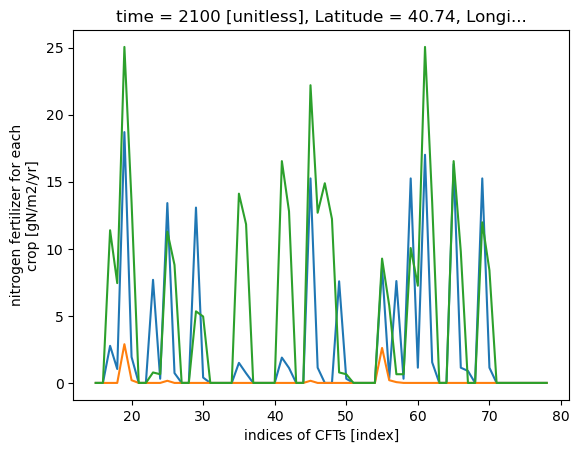

In [5]:
dset1['FERTNITRO_CFT'].sel(time=2100, Latitude=40, Longitude= 100, method='nearest').plot()
dset1['FERTNITRO_CFT'].sel(time=2100, Latitude=50, Longitude= 100, method='nearest').plot()
dset1['FERTNITRO_CFT'].sel(time=2100, Latitude=40, Longitude= 80, method='nearest').plot()

[]

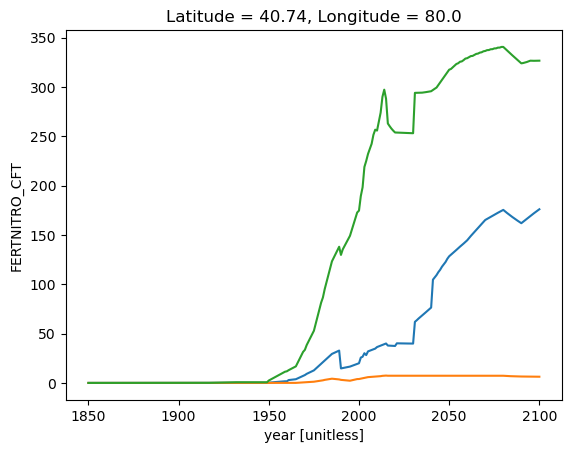

In [7]:

dset1['FERTNITRO_CFT'].sel(Latitude=40, Longitude= 100, method='nearest').sum('cft').plot()
dset1['FERTNITRO_CFT'].sel(Latitude=50, Longitude= 100, method='nearest').sum('cft').plot()
dset1['FERTNITRO_CFT'].sel(Latitude=40, Longitude= 80, method='nearest').sum('cft').plot()
plt.plot()

Text(0.5, 0, 'FERTNITRO_CFT')

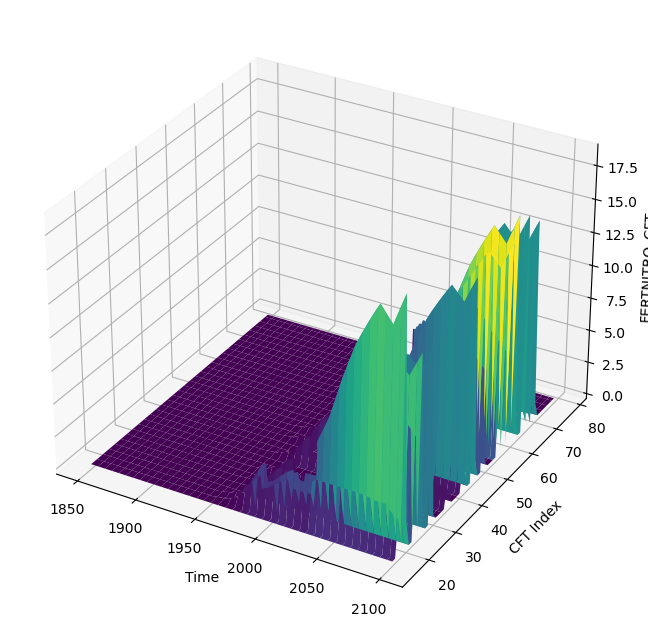

In [55]:

# Select the data for the specified time, cft index, latitude, and longitude
data=dset1['FERTNITRO_CFT'].sel(Latitude=40, Longitude= 100, method='nearest').values
time=dset1['time']
cft=dset1['cft']
time_mesh, cft_mesh = np.meshgrid(time, cft)
# Create the 3D surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(time_mesh, cft_mesh, data.T, cmap='viridis')
ax.set_xlabel('Time')
ax.set_ylabel('CFT Index')
ax.set_zlabel('FERTNITRO_CFT')


##convert PCT_CFT to area and back to PCT_CFT, just to check whether the conversion works, dont execute it now

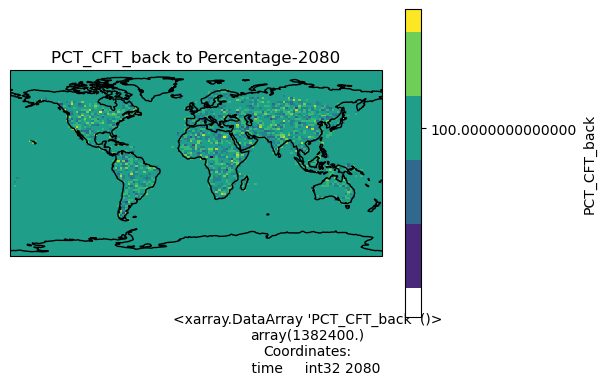

In [21]:
dset1['PCT_CFT_back'] = xr.zeros_like(dset1['PCT_CFT_area'])
dset1['PCT_CFT_back'] = xr.where(dset1['PCT_CROP'] > 0, (dset1['PCT_CFT_area'] / (dset1['AREA'] * (dset1['PCT_CROP'] / 100))) * 100, dset1['PCT_CFT_back'])

# Set 'PCT_CFT_back' to 'PCT_CFT' where 'PCT_CROP' is zero, over ocean over and artic and antarctic regions.
dset1['PCT_CFT_back'] = xr.where(dset1['PCT_CROP'] == 0, dset1['PCT_CFT'], dset1['PCT_CFT_back'])

#dset1['PCT_CFT_back'] = dset1['PCT_CFT_back'].fillna(0)
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})  # The value of PCT_CFT over ocean is 100 when cft is 15 and is zero for all other cfts.
dset1['PCT_CFT_back'].sum('cft').sel(time=2080).plot()
plt.text(0.8, -0.3, dset1['PCT_CFT_back'].sum('cft').sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);

plt.title('PCT_CFT_back to Percentage-2080')
axs.coastlines(linewidth=1)


<xarray.DataArray 'PCT_CFT' (Latitude: 96, Longitude: 144)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * Latitude   (Latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * Longitude  (Longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
    cft        int32 52


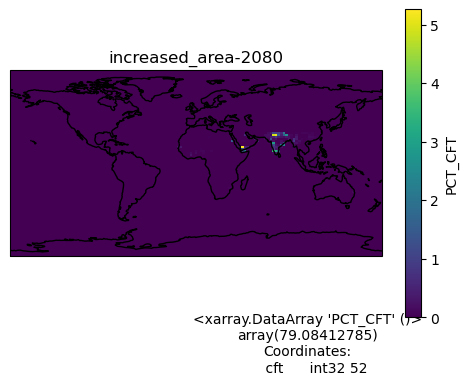

In [3]:
#Find the total area in 2090 without sugarcane
TotCFTArea_2080_wosugarcane=(dset1['PCT_CFT'].sel(time=2080).sum('cft'))-(dset1['PCT_CFT'].loc[dict(cft=52, time=2080)]) 
TotCFTArea_2015_wosugarcane=(dset1['PCT_CFT'].sel(time=2015).sum('cft'))-(dset1['PCT_CFT'].loc[dict(cft=52, time=2015)]) 
#Find the increase in tot area in 2090 wrt 2015 
TotCFTArea_diff_2080 = TotCFTArea_2080_wosugarcane -TotCFTArea_2015_wosugarcane  # increased area in 2090 wo sugarcane

increased_area = xr.where(TotCFTArea_diff_2080 > 0, TotCFTArea_diff_2080, 0)

print(increased_area)

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
increased_area.plot()
plt.title('increased_area-2080')
plt.text(0.8, -0.3, increased_area.sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
axs.coastlines(linewidth=1) 

#  Add the increased area to the specific cft in 2080, ##2015 area+ increased
updated_cft_60_2080 =  increased_area # dset1['PCT_CFT_area'].loc[dict(cft=60, time=2015)] + increased_area

# Now, Assign the updated values to the specific cft at time=2090
dset1['PCT_CFT'].loc[dict(cft=60, time=2080)] = updated_cft_60_2080
#dset1['PCT_CFT_area'].loc[dict(cft=60, time=2090)] = filtered_data  # Attribute the increased area to a specific crop (crop)



<xarray.DataArray 'PCT_CFT' ()>
array(519.88533546)
Coordinates:
    cft      int32 52
    time     int32 2080


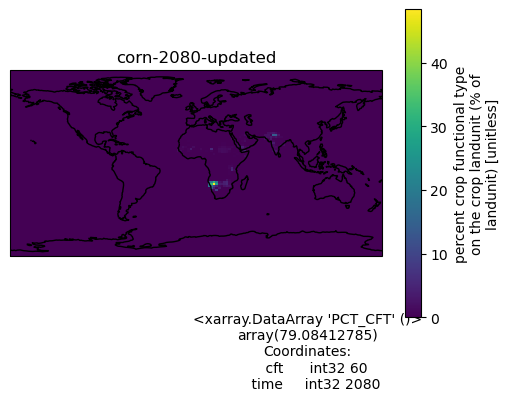

In [7]:
#Now,copy and keep the sugarcane and corn (increased) area of 2090 into a new variable 
cft_52_2080 = dset1['PCT_CFT'].loc[dict(cft=52, time=2080)].copy()  # Select the values for cft=52 in 2080, sugarcane
cft_60_2080 = dset1['PCT_CFT'].loc[dict(cft=60, time=2080)].copy()  # Select the values for cft=60 in 2080, corn
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
cft_52_2080.plot()
plt.title('corn-2080-updated')
plt.text(0.8, -0.3, cft_60_2080.sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
axs.coastlines(linewidth=1)


print(cft_52_2080.sum())

##Creating a new variable for the new data

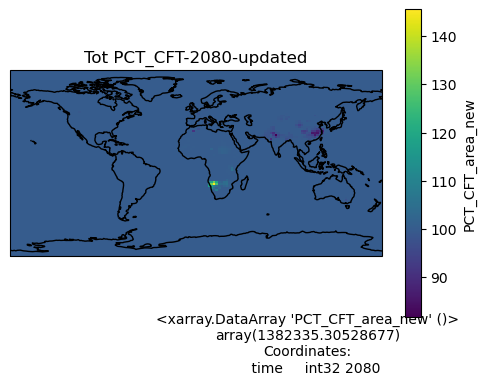

In [5]:
dset1['PCT_CFT_area_new'] = xr.zeros_like(dset1['PCT_CFT'])
dset1['PCT_CFT_area_new'].sel(time=2080)[:] = dset1['PCT_CFT'].sel(time=2015)
dset1['PCT_CFT_area_new'].loc[dict(cft=60, time=2080)] = cft_60_2080
dset1['PCT_CFT_area_new'].loc[dict(cft=52, time=2080)] = cft_52_2080

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT_area_new'].sum('cft').sel(time=2080).plot()
axs.coastlines(linewidth=1)
plt.title('Tot PCT_CFT-2080-updated')
plt.text(0.8, -0.3, dset1['PCT_CFT_area_new'].sum('cft').sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);




In [6]:
print(dset1['PCT_CFT_area_new'].sum('cft').sel(time=2080).sum())
print(dset1['PCT_CFT_area_original'].sum('cft').sel(time=2080).sum())
print(dset1['PCT_CFT_area_new'].sum('cft').sel(time=2080).sum()-dset1['PCT_CFT_area_original'].sum('cft').sel(time=2080).sum())
print((dset1['PCT_CFT_area_new'].sum('cft').sel(time=2080)-dset1['PCT_CFT_area_original'].sum('cft').sel(time=2080)).sum())


<xarray.DataArray 'PCT_CFT_area_new' ()>
array(1382335.30528677)
Coordinates:
    time     int32 2080


KeyError: 'PCT_CFT_area_original'

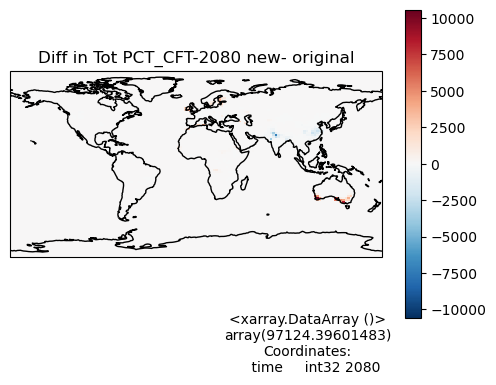

In [29]:
diff_newdata=dset1['PCT_CFT_area_new'].sum('cft').sel(time=2080)-(dset1['PCT_CFT_area_original'].sum('cft').sel(time=2080))
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
diff_newdata.plot()
axs.coastlines(linewidth=1)
plt.title('Diff in Tot PCT_CFT-2080 new- original')
plt.text(0.8, -0.3, diff_newdata.sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);

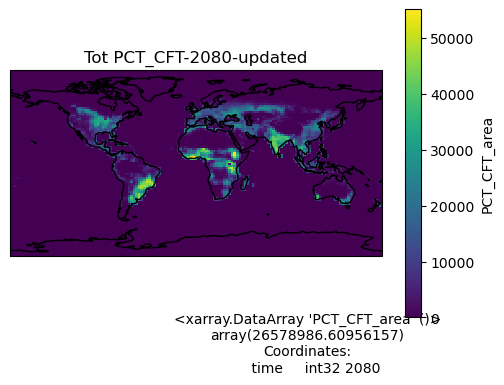

In [6]:
# creating the new dataset of 2080, first copy 2015 data to 2080, and replace the corn and sugarcane with the new calculated one
dset1['PCT_CFT_area'].sel(time=2080)[:] = dset1['PCT_CFT_area'].sel(time=2015)
dset1['PCT_CFT_area'].loc[dict(cft=60, time=2080)] = cft_60_2080
dset1['PCT_CFT_area'].loc[dict(cft=52, time=2080)] = cft_52_2080

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT_area'].sum('cft').sel(time=2080).plot()
axs.coastlines(linewidth=1)
plt.title('Tot PCT_CFT-2080-updated')
plt.text(0.8, -0.3, dset1['PCT_CFT_area'].sum('cft').sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);


##Somehow this is not working

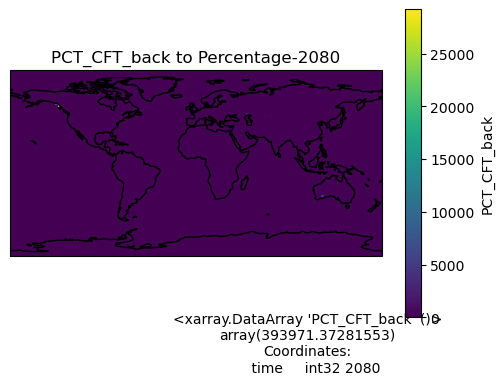

In [19]:
dset1['PCT_CFT_back'] = xr.zeros_like(dset1['PCT_CFT_area_new'])
dset1['PCT_CFT_back'] = xr.where(dset1['PCT_CROP'] > 0, (dset1['PCT_CFT_area_new'] / (dset1['AREA'] * (dset1['PCT_CROP'] / 100))) * 100, dset1['PCT_CFT_back'])

# Set 'PCT_CFT_back' to 'PCT_CFT' where 'PCT_CROP' is zero, over ocean over and artic and antarctic regions.
dset1['PCT_CFT_back'] = xr.where(dset1['PCT_CROP'] == 0, dset1['PCT_CFT'], dset1['PCT_CFT_back'])

#dset1['PCT_CFT_back'] = dset1['PCT_CFT_back'].fillna(0)
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})  # The value of PCT_CFT over ocean is 100 when cft is 15 and is zero for all other cfts.
dset1['PCT_CFT_back'].sum('cft').sel(time=2080).plot()
plt.text(0.8, -0.3, dset1['PCT_CFT_back'].sum('cft').sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);

plt.title('PCT_CFT_back to Percentage-2080')
axs.coastlines(linewidth=1)


Text(0.5, 1.0, 'PCT_CFT_area-2015-without corn and cane')

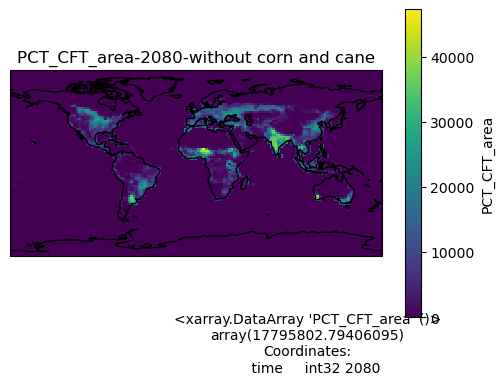

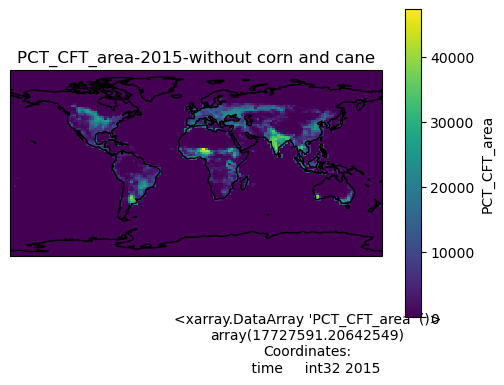

In [31]:
TotCFTArea_2015_wocanecorn=TotCFTArea_2015_wosugarcane-(dset1['PCT_CFT_area'].loc[dict(cft=60, time=2015)]) 
TotCFTArea_2080_wocanecorn=TotCFTArea_2080_wosugarcane-(dset1['PCT_CFT_area'].loc[dict(cft=60, time=2080)]) 
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
TotCFTArea_2080_wocanecorn.plot()
axs.coastlines(linewidth=1)
plt.text(0.8, -0.3, TotCFTArea_2080_wocanecorn.sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT_area-2080-without corn and cane')

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
TotCFTArea_2015_wocanecorn.plot()
axs.coastlines(linewidth=1)
plt.text(0.8, -0.3, TotCFTArea_2015_wocanecorn.sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT_area-2015-without corn and cane')

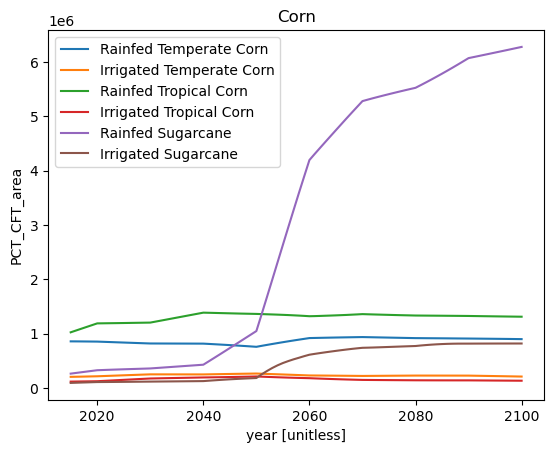

In [3]:
start_time = '2015'
end_time = '2100'
fig, ax = plt.subplots()
dset1['PCT_CFT_area'].sum(dim=('Latitude', 'Longitude')).loc[dict(cft=17)].sel(time=slice(start_time, end_time)).plot(label='Rainfed Temperate Corn', ax=ax)
dset1['PCT_CFT_area'].sum(dim=('Latitude', 'Longitude')).loc[dict(cft=18)].sel(time=slice(start_time, end_time)).plot(label='Irrigated Temperate Corn', ax=ax)
dset1['PCT_CFT_area'].sum(dim=('Latitude', 'Longitude')).loc[dict(cft=75)].sel(time=slice(start_time, end_time)).plot(label='Rainfed Tropical Corn', ax=ax)
dset1['PCT_CFT_area'].sum(dim=('Latitude', 'Longitude')).loc[dict(cft=76)].sel(time=slice(start_time, end_time)).plot(label='Irrigated Tropical Corn', ax=ax)
plt.title('Corn')
plt.legend()

dset1['PCT_CFT_area'].sum(dim=('Latitude', 'Longitude')).loc[dict(cft=67)].sel(time=slice(start_time, end_time)).plot(label='Rainfed Sugarcane', ax=ax)
dset1['PCT_CFT_area'].sum(dim=('Latitude', 'Longitude')).loc[dict(cft=68)].sel(time=slice(start_time, end_time)).plot(label='Irrigated Sugarcane', ax=ax)

plt.title('Corn')
plt.legend()

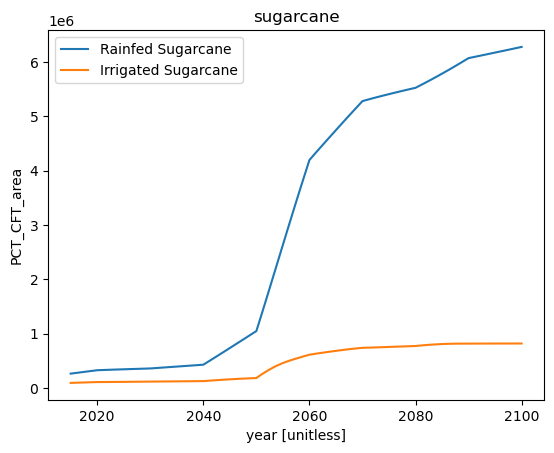

In [11]:
start_time = '2015'
end_time = '2100'
fig, ax = plt.subplots()
dset1['PCT_CFT_area'].sum(dim=('Latitude', 'Longitude')).loc[dict(cft=67)].sel(time=slice(start_time, end_time)).plot(label='Rainfed Sugarcane', ax=ax)
dset1['PCT_CFT_area'].sum(dim=('Latitude', 'Longitude')).loc[dict(cft=68)].sel(time=slice(start_time, end_time)).plot(label='Irrigated Sugarcane', ax=ax)
plt.title('sugarcane')
plt.legend()

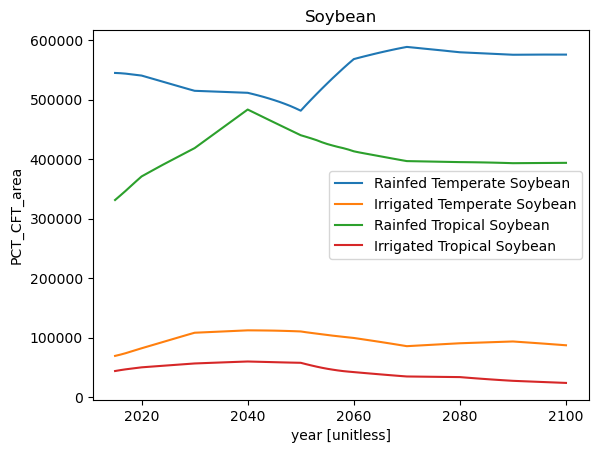

In [13]:
start_time = '2015'
end_time = '2100'
fig, ax = plt.subplots()
dset1['PCT_CFT_area'].sum(dim=('Latitude', 'Longitude')).loc[dict(cft=23)].sel(time=slice(start_time, end_time)).plot(label='Rainfed Temperate Soybean', ax=ax)
dset1['PCT_CFT_area'].sum(dim=('Latitude', 'Longitude')).loc[dict(cft=24)].sel(time=slice(start_time, end_time)).plot(label='Irrigated Temperate Soybean', ax=ax)
dset1['PCT_CFT_area'].sum(dim=('Latitude', 'Longitude')).loc[dict(cft=77)].sel(time=slice(start_time, end_time)).plot(label='Rainfed Tropical Soybean', ax=ax)
dset1['PCT_CFT_area'].sum(dim=('Latitude', 'Longitude')).loc[dict(cft=78)].sel(time=slice(start_time, end_time)).plot(label='Irrigated Tropical Soybean', ax=ax)
plt.title('Soybean')
plt.legend()